# Inventory Monitoring at Distribution Centers
Today, warehouses are constantly growing in size and complexity and it's important to develop efficient processes that can accurately track the inventory. A major player in the field of warehouse management is Amazon. I’m interested in how a company, such as Amazon, has been able to build global warehouse management systems, and I want to look into how to streamline and improve processes in these systems.

AWS SageMaker has been leveraged to fine-tune a pre-trained model for the task of detecting the number of items in an image of a bin.  The photos are taken by warehouse robots. The bins are stacked in moveable shelves in the distribution center. This project is designed to simulate a typical workflow that a machine learning engineer would undertake.

In [10]:
####################################################################################################
# Following references have been used in Project Inventory Monitoring at Distribution Centers
# - Starter code provided by Udacity in the projects of the AWS Machine Learning Engineer Nanodegree
# - The official documentation for Amazon SageMaker: https://docs.aws.amazon.com/sagemaker/
####################################################################################################

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import sagemaker
import boto3
import os
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from tqdm import tqdm

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Data Preparation


The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets yet. 

In [7]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:27<00:00, 14.07it/s]


100%|██████████| 2299/2299 [02:46<00:00, 13.82it/s]


100%|██████████| 2666/2666 [03:16<00:00, 13.59it/s]


100%|██████████| 2373/2373 [02:52<00:00, 13.77it/s]


100%|██████████| 1875/1875 [02:16<00:00, 13.75it/s]


## Dataset
The Amazon Bin Image Dataset has been used to classify number of items in warehouse bins.  The dataset contains 500,000 images. A subset of these images have been downloaded by means of the code above. This subset contains 10,441 images, which represents about 2% of the total number of images. These images have been divided into 5 categories (classes), where each category represents the number of items per bin. The distribution of images is as follows:  1228 (1 item), 2299 (2 items), 2666 (3 items), 2373 (4 items) and 1875 (5 items). More information about the data can be found [here](https://registry.opendata.aws/amazon-bin-imagery/). This data subset has been uploaded to Amazon S3 and split into 3 folders: train, test and valid. In S3, the data split is 90/5/5.

In [3]:
# %%capture
# Upload the data to AWS S3
# !aws s3 cp train_data s3://project-inventory-monitoring/train/ --recursive
# Split data in test, train and validation 

In [3]:
!aws s3 ls s3://project-inventory-monitoring/train/1/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/train/2/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/train/3/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/train/4/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/train/5/ --recursive | wc -l 

1103
2069
2398
2135
1687


In [4]:
!aws s3 ls s3://project-inventory-monitoring/test/1/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/test/2/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/test/3/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/test/4/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/test/5/ --recursive | wc -l 

62
115
134
119
94


In [5]:
!aws s3 ls s3://project-inventory-monitoring/valid/1/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/valid/2/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/valid/3/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/valid/4/ --recursive | wc -l 
!aws s3 ls s3://project-inventory-monitoring/valid/5/ --recursive | wc -l 

63
115
134
119
94


## Model Training
Below is model training without hyperparamater tuning or debugging/profiling 

Note: The `train.py` script has been used to train the model.

In [9]:
# Declare the model training hyperparameters
# NOTE: Fixed values are used i.e. no hyperparameter tuning
hyperparameters = {'batch_size': 128, 'learning_rate': 0.0005, 'epochs': 5}
role = sagemaker.get_execution_role()

In [10]:
# Create the training estimator
estimator = PyTorch(
    entry_point='train.py',  # uses the model training script: train.py"
    base_job_name='inventory-pytorch',
    role=role,
    instance_count=1,  # single-instance training
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
)

In [11]:
# Fit the estimator
estimator.fit({"training": "s3://project-inventory-monitoring/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: inventory-pytorch-2024-08-17-18-16-33-246


2024-08-17 18:16:34 Starting - Starting the training job...
2024-08-17 18:16:50 Starting - Preparing the instances for training...
2024-08-17 18:17:23 Downloading - Downloading input data...
2024-08-17 18:17:58 Downloading - Downloading the training image.........
2024-08-17 18:19:19 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-17 18:19:31,511 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2024-08-17 18:19:31,542 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-17 18:19:31,544 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-17 18:19:31,735 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2024-08-17 18:19:31,735 sagemaker-containers INFO     Generating setup.cfg
2

## Hyperparameter Tuning
In this section, hyperparameter tuning has been carried out.  Three hyperparameters have been optimized: learning_rate, batch_size and epochs. Theses are typical hyperparameters that are tuned during image classification tasks.  Suitable parameter ranges have been chosen taking into consideration aspects such as cost, duration and instance type.

In [6]:
# Declare hyperparameter ranges and metrics 
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.00001, 0.01),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": IntegerParameter(10, 20)
}
role = sagemaker.get_execution_role()
objective_metric_name = "Test Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Test Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [7]:
# Create the estimator for training
estimator = PyTorch(
    entry_point="hpo.py",  # uses the model training script: hpo.py"
    base_job_name='pytorch_inventory_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,  # single-instance training
    instance_type="ml.g4dn.xlarge", 
    py_version='py3'
)
# Create the hyperparameter tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,  
    objective_type=objective_type
)

In [8]:
# Fit the estimator
os.environ['SM_CHANNEL_TRAINING']='s3://project-inventory-monitoring/'
os.environ['SM_MODEL_DIR']='s3://project-inventory-monitoring/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://project-inventory-monitoring/output/'
tuner.fit({"training": "s3://project-inventory-monitoring/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................................................................!


In [9]:
# Description of the tuning results
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-240818-1211')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""256""",13.0,0.000212,pytorch-training-240818-1211-001-32b2e2e9,Completed,54.0,2024-08-18 12:12:43+00:00,2024-08-18 12:39:03+00:00,1580.0
0,"""256""",14.0,0.000147,pytorch-training-240818-1211-002-53cca75b,Completed,53.0,2024-08-18 12:12:42+00:00,2024-08-18 12:39:57+00:00,1635.0


In [10]:
# Get the best estimator
best_estimator = tuner.best_estimator()


2024-08-18 12:39:06 Starting - Preparing the instances for training
2024-08-18 12:39:06 Downloading - Downloading the training image
2024-08-18 12:39:06 Training - Training image download completed. Training in progress.
2024-08-18 12:39:06 Uploading - Uploading generated training model
2024-08-18 12:39:06 Completed - Resource retained for reuse


In [11]:
# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Accuracy"',
 'batch_size': '"256"',
 'epochs': '13',
 'learning_rate': '0.00021192942120791476',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_inventory_hpo-2024-08-18-12-11-46-550"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-310915493401/pytorch_inventory_hpo-2024-08-18-12-11-46-550/source/sourcedir.tar.gz"'}

In [12]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": float(best_estimator.hyperparameters()['learning_rate']),
                   "epochs": int(best_estimator.hyperparameters()['epochs'])}
hyperparameters

{'batch_size': 256, 'learning_rate': 0.00021192942120791476, 'epochs': 13}

## Model Profiling and Debugging
Using the optimized hyperparameters, a new estimator has been created. Model profiling and debugging have been included.

In [11]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [44]:
# Using spot instances lowers the cost. On demand price of instance-type g4dn.xlarge is $0.526
# whereas as the spot price is $0.1635
use_spot_instances = True
max_run=4800
max_wait = 5400 if use_spot_instances else None
instance_count = 1

In [45]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',  # use the model training script: train.py"
    base_job_name='inventory-pytorch',
    role=role,
    instance_count=instance_count,  
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    # Debugger and profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    # Spot instance parameters
    use_spot_instances=use_spot_instances,
    max_run = max_run,
    max_wait = max_wait,  
)

estimator.fit({"training": "s3://project-inventory-monitoring/"}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2024-08-18 14:04:12 Starting - Starting the training job...
2024-08-18 14:04:40 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-08-18 14:05:06 Downloading - Downloading input data...
2024-08-18 14:05:40 Downloading - Downloading the training image.........
2024-08-18 14:07:07 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-18 14:07:02,082 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2024-08-18 14:07:02,113 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-18 14:07:02,115 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-18 14:

In [46]:
# Plot a debugging output.
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: inventory-pytorch-2024-08-18-14-04-11-628
Region: us-east-1


In [47]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
# Create trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-08-18 14:35:57.390 default:109 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/debug-output


In [48]:
# Print list of tensors and crossentropy loss 
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2024-08-18 14:35:57.718 default:109 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-18 14:35:58.742 default:109 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.rel

In [49]:
!pip install bokeh==2.4.3

In [50]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
# Define training job for profiler
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-310915493401/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/profiler-output


Profiler data from system is available


In [51]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
framework_metrics_reader = tj.get_framework_metrics_reader()
system_metrics_reader.refresh_event_file_list()

In [52]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2024-08-18 14:36:07.043 default:109 INFO metrics_reader_base.py:134] Getting 31 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [53]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

system_metrics_reader.refresh_event_file_list()
view_heatmap = Heatmap(system_metrics_reader, plot_height=450)

[2024-08-18 14:36:12.062 default:109 INFO metrics_reader_base.py:134] Getting 31 event files
select events:['.*']
select dimensions:['.*CPU', '.*GPU']
filtered_events:{'cpu2', 'MemoryUsedPercent', 'cpu1', 'gpu0', 'ReceiveBytesPerSecond', 'IOPS', 'cpu3', 'total', 'cpu0', 'TransmitBytesPerSecond', 'WriteThroughputInBytesPerSecond', 'ReadThroughputInBytesPerSecond'}
filtered_dimensions:{'CPUUtilization', 'GPUUtilization', 'GPUMemoryUtilization'}


**Anomalous behavior**: There does not appear to be an anomolous behavior in the timeline chart and heatmap.  The offloading to the GPU appears to work fine. However, if there was a problem with the EC2 instance, for example, CUDA was not available, then the graph will indicate so. 

In [54]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/rule-output


In [55]:
!aws s3 ls {rule_output_path} --recursive

2024-08-18 14:34:25     361688 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-08-18 14:34:24     208601 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-08-18 14:34:20        192 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-08-18 14:34:20      64172 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-08-18 14:34:20        126 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-08-18 14:34:20        332 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-08-18 14:34:20      15996 inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/prof

In [56]:
!aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-0

In [68]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [70]:
#import IPython

#Python.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deployment and Querying
The model has been deployed to a SageMaker endpoint, and inference has been carried out on a chosen bin image from the test directory.

In [61]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [62]:
# Deploy model to an endpoint, including configuration such as instance type and number of instances
model_location=estimator.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-310915493401/inventory-pytorch-2024-08-18-14-04-11-628/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-310915493401/pytorch-inference-2024-08-18-14-45-12-089/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-08-18-14-45-28-313
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-08-18-14-45-29-048
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-08-18-14-45-29-048


------!

In [71]:
# Run a prediction on the endpoint
with open("00371.jpg", "rb") as f:   # Image retrieved from the test directory
    img_bytes = f.read()

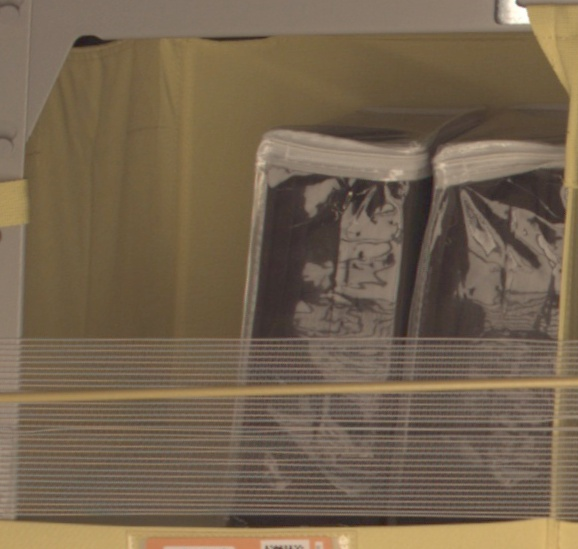

In [72]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [73]:
# Create response
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [74]:
print(response)

[[-0.362534761428833, 0.6582372188568115, 0.28011247515678406, -0.30681028962135315, -0.7934650182723999]]


In [79]:
max_value = response[0].index(max(response[0]))
max_value
# The value 1 is index number in the list. This corresponds to 2 objects as indexing begins at zero.
# Therefore, the model correctly predicts number of items in the image.

1

In [80]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-08-18-14-45-29-048
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-08-18-14-45-29-048


### Cost Analysis
#### Cheaper training: 
At the time or writing, the on-demand price of instance-type g4dn.xlarge was 0.526 (dollars) per hour whereas the spot price of the same instance-type was 0.1559 (dollars) per hour. It is assumed that these instances have been set up with Linux. In other words, using spot instances provides a significant saving. To use spot instance, set parameters 'use_spot_instances', 'max_run' and 'max_wait' when creating the estimator. Spot instances have been used earlier in this notebook to carry out training. See previous section "Model Profiling and Debugging". Also, below is an example of how to define parameters needed for spot instances. 

In [8]:
hyperparameters = {'batch_size': 128, 'learning_rate': 0.0005, 'epochs': 5}
role = sagemaker.get_execution_role()

In [9]:
use_spot_instances = True
max_run=600
max_wait = 1200 if use_spot_instances else None
instance_count = 1

In [10]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',  # use model training script: train.py
    base_job_name='inventory-pytorch',
    role=role,
    instance_count=instance_count,  # single-instance training
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    # Spot instance parameters
    use_spot_instances=use_spot_instances,
    max_run = max_run,
    max_wait = max_wait,  
)

estimator.fit({"training": "s3://project-inventory-monitoring/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: inventory-pytorch-2024-08-19-11-08-53-405


2024-08-19 11:08:54 Starting - Starting the training job...
2024-08-19 11:09:08 Starting - Preparing the instances for training...
2024-08-19 11:09:41 Downloading - Downloading input data...
2024-08-19 11:10:17 Downloading - Downloading the training image.........
2024-08-19 11:11:38 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-19 11:11:50,194 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2024-08-19 11:11:50,224 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-19 11:11:50,226 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-19 11:11:50,383 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2024-08-19 11:11:50,384 sagemaker-containers INFO     Generating setup.cfg
2

### Multi-Instance Training
To use multi-instance training is relatively easy in SageMaker compared to other systems. It is done by setting the parameter 'instance_count' to the desired number instances when creating the estimator. SageMaker then figures out how to do the rest. The current quota, assigned to the user account in this project, allows only for a maximum of 2 instances hence 'instance_count' has been set to 2. Also, the current quota does not allow for the use of spot instances hence the corresponding spot instance parameters have been omitted when creating the estimator.  The main reason for using multiple instances is to speed up the training. However,  in this project, the training is relatively quick when having just one EC2 instance. There seems to be no major benefit to using multiple instances. This is because the training dataset is relatively small. Also, the training has been speeded up by offloading to the GPU (CUDA). It is also possible to have multi-instance training with distributed data i.e. the data is sharded (split) between multiple instances. However, again as the dataset used for training is relatively small, it does not seem to be beneficial to use sharded data. 

In [15]:
# Declare model training hyperparameters. The optimized values obtained previously during hyperparameter tuning have been used.
hyperparameters = {'batch_size': 256, 'learning_rate': 0.00021192942120791476, 'epochs': 13}
role = sagemaker.get_execution_role()

In [16]:
# Set the number of EC2 instances to 2
instance_count = 2

In [17]:
# Create the estimator for training
estimator = PyTorch(
    entry_point='train.py',  # use model training script: train.py
    base_job_name='inventory-pytorch',
    role=role,
    instance_count=instance_count,  
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    # Debugger and profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config, 
)

estimator.fit({"training": "s3://project-inventory-monitoring/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: inventory-pytorch-2024-08-19-12-07-26-365


2024-08-19 12:07:26 Starting - Starting the training job...
2024-08-19 12:07:55 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-08-19 12:08:27 Downloading - Downloading input data...
2024-08-19 12:08:55 Downloading - Downloading the training image.........
2024-08-19 12:10:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-19 12:10:22,316 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2024-08-19 12:10:22,347 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
202